<a href="https://colab.research.google.com/github/Yuefan18/Project-2024-2025/blob/main/Citi_Bike_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade gensim pyLDAvis spacy pandas scikit-learn emoji

In [ ]:
#There is one warning about DateTime that we can ignore so this line of code is run.
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [ ]:
#Import all necessary libraries
import emoji
import math
import spacy.cli
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import string
import spacy
import nltk
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from nltk.corpus import stopwords
spacy.cli.download("en_core_web_md")
import en_core_web_md
nltk.download('wordnet')
nltk.download('stopwords')
import umap.umap_ as umap
from wordcloud import WordCloud

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Preliminaries

The first step in any data analysis process is to collect relevant data of interest from a diverse set of sources.

The good news is that we have already scraped high quality user comments about their experiences with bike sharing from Reddit, Twitter and various Community Forums. You can access this data from [this link](https://drive.google.com/file/d/1RljfuC3P-7SXNmBwFwJp8cMFhu6FUJCd/view?usp=drive_link).

Your first task is to downlowad this data and upload it to this notebook. You can drag-drop the downlowded data file to this notebook's <code>sample_data</code> folder (see the folder icon on the left panel).

In [ ]:
try:

# Load Citi Bike Reddit data
  reddit = pd.read_csv("citibike_and_nycbike_reddit_data.csv")
  liwc   = pd.read_csv("liwc_reddit_data.csv")
  abbr   = pd.read_csv("abbreviations.csv", header=None, names=["abbr","full"])
  abbreviations_dict = dict(zip(abbr["abbr"].astype(str), abbr["full"].astype(str)))

  print(f"Loaded {len(reddit)} comments \n")
  print(reddit.head())
except Exception:
  print("Hey, it looks like something went wrong. Did you copy the file at the right place?")

Loaded 1000 comments 

        id subreddit                                            comment  \
0  1fdj6h7  Citibike  r/CitiBike Lost and Found #Please use this thr...   
1  1nach74  Citibike  lost citibike key if anyone has seen a set of ...   
2  1n95r44  Citibike  Left bag in citibike (UES Station) I know this...   
3  1n8as57  Citibike  Citibike station on w44th street and 11th aven...   
4  1n8att9  Citibike  Free Ebike Rides w Lyft Pink ? Have ridden a f...   

                                          source_url  score  \
0  https://www.reddit.com/r/Citibike/comments/1fd...     11   
1  https://www.reddit.com/r/Citibike/comments/1na...      1   
2  https://www.reddit.com/r/Citibike/comments/1n9...      5   
3  https://w42st.com/post/early-morning-blaze-tor...      8   
4                https://i.redd.it/dcx6sw4tl5nf1.png      3   

               created  
0  2024-09-10 10:26:34  
1  2025-09-06 18:17:25  
2  2025-09-05 09:47:38  
3  2025-09-04 09:54:47  
4  2025-09-04 09:56:34

#Activity 1: Basic Data Exploration

Once you collect/obtain any new data, you first goal should be to get a *feel* for it. In the context of the <code>bike_share</code> you just uploaded to this notebook, how many user comments were collected? What is the basic demographic makup of the users? What proportion of data was collected from the various sources?

These are just some of the very basic questions which can help you understand the data you just collected. It can help you understand some basic trends and potential data collection issues that may be present in your data.

Your goal here is to get a few sentence summary of some of the interesting characteristics of your dataset. Some (non-comprehensive) things to consider:

- what are the most common words/phrases used in the comments?
- what is the average length of comment?
- what is the demographic makup of the users?

You should come up with some of your own interesting questions and try to answer them. If needed, don't be afraid to to ask for help!


In [ ]:
print(reddit.columns.tolist())


['id', 'subreddit', 'comment', 'source_url', 'score', 'created']


In [ ]:
raw_col = 'comment' if 'comment' in reddit.columns else (
    'body' if 'body' in reddit.columns else None
)
assert raw_col is not None, f"No raw text column found. Available columns: {reddit.columns.tolist()}"

import re, string, emoji
def basic_clean(s):
  s = emoji.demojize(str(s))
  s = re.sub(r'https?://\S+|www\.\S+', ' ', s)
  s = s.lower()
  s = s.translate(str.maketrans({ch:' ' for ch in string.punctuation}))
  return ' '.join(w for w in s.split() if len(w) >= 3)
reddit['text_clean'] = reddit[raw_col].astype(str).apply(basic_clean)


In [ ]:
from collections import Counter

word_frequency = Counter()
for comment in reddit['text_clean']:
    word_frequency.update(comment.split())

frequency_values = list(word_frequency.values())


In [ ]:
#Keep track of every word and its occurrences
word_frequency = {}
for comment in reddit["text_clean"]:
    for word in comment.split():
        word_frequency[word] = word_frequency.get(word, 0) + 1

frequency_values = list(word_frequency.values())



In [ ]:
# Convert the dictionary to a list of tuples and sort by frequency
sorted_word_frequency = sorted(word_frequency.items(), key=lambda item: item[1], reverse=True)

for word, count in sorted_word_frequency[:100]:
    print(f"{word}: {count}")

the: 2869
and: 1655
bike: 1086
for: 830
this: 623
that: 574
was: 477
but: 470
you: 454
have: 432
with: 432
are: 325
citibike: 319
not: 309
ride: 295
they: 287
just: 286
from: 284
bikes: 277
there: 242
get: 242
out: 239
like: 224
can: 221
what: 207
one: 199
any: 196
when: 195
all: 192
anyone: 191
would: 186
has: 184
had: 180
i’m: 171
about: 171
how: 166
been: 160
new: 160
citi: 144
riding: 141
back: 139
your: 139
know: 138
lyft: 134
got: 133
time: 132
them: 132
membership: 132
lane: 132
some: 131
now: 130
more: 127
their: 126
park: 125
way: 124
city: 120
around: 119
dock: 114
nyc: 113
it’s: 110
which: 104
street: 102
then: 102
were: 100
will: 100
use: 99
other: 99
take: 97
see: 97
could: 94
does: 93
here: 93
where: 93
after: 93
day: 92
into: 91
points: 91
only: 91
who: 89
even: 89
going: 88
looking: 88
over: 87
did: 87
before: 86
these: 85
down: 85
station: 84
than: 83
people: 83
first: 82
want: 82
off: 82
also: 81
biking: 79
why: 78
while: 78
good: 78
right: 78
work: 77


In [ ]:
#This is a helper method for generating histograms
def generate_hist(threshold,bucket_size,color="skyblue"):
  frequency_values_beyond_threshold = []
  for freq in frequency_values:
    if(freq >= threshold):
      frequency_values_beyond_threshold.append(freq)
  plt.hist(frequency_values_beyond_threshold, bins=range(min(frequency_values_beyond_threshold), max(frequency_values_beyond_threshold) + bucket_size, bucket_size), color=color)
  plt.xlabel('Frequency')
  plt.ylabel('Count')
  plt.title('Histogram of Word Frequencies')
  plt.show()

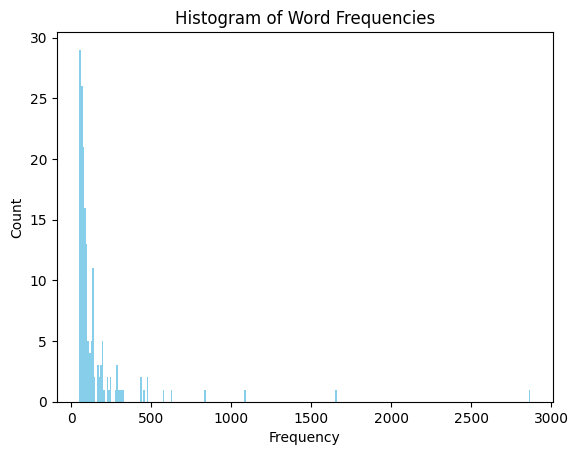

In [ ]:
#Plotting a histogram for the frequencies of all words
#threshold is the minimum frequency allowed, as a lot of words
#will have frequency 1 and we might not want to plot those
#bucket_size is the width of each histogram "bucket"

threshold = 50 #Insert Value Here
bucket_size = 10 #Insert Value Here
generate_hist(threshold=threshold,bucket_size=bucket_size)

In [ ]:
#Prints the list of the most frequent words above certain threshold

threshold = 50 #Insert Value Here
words_beyond_threshold = []
for word,freq in word_frequency.items():
  if(freq >= threshold):
    words_beyond_threshold.append(f"{word}: {freq}")
print('\n'.join(words_beyond_threshold))

citibike: 319
and: 1655
found: 55
use: 99
this: 623
bikes: 277
that: 574
are: 325
have: 432
been: 160
not: 309
with: 432
lyft: 134
last: 70
street: 102
ave: 75
city: 120
key: 61
anyone: 191
has: 184
the: 2869
dock: 114
left: 67
station: 84
know: 138
but: 470
citi: 144
bike: 1086
time: 132
had: 180
through: 68
were: 100
how: 166
does: 93
just: 286
free: 54
rides: 68
pink: 52
few: 64
week: 62
since: 66
back: 139
from: 284
they: 287
all: 192
out: 239
what: 207
these: 85
used: 67
help: 56
around: 119
here: 93
first: 82
ride: 295
miles: 65
going: 88
other: 99
docks: 62
any: 196
would: 186
more: 127
for: 830
i’m: 171
long: 75
getting: 75
now: 130
it’s: 110
like: 224
you: 454
your: 139
today: 73
when: 195
new: 160
i’ve: 75
was: 477
riding: 141
looking: 88
between: 57
his: 61
there: 242
where: 93
before: 86
another: 52
then: 102
side: 65
manhattan: 74
bridge: 65
which: 104
tried: 59
over: 87
them: 132
did: 87
two: 74
think: 65
some: 131
can: 221
take: 97
their: 126
could: 94
app: 62
one: 199
a

What are some interesting details you observe?

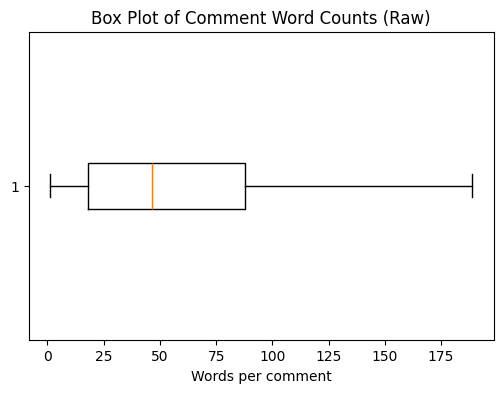

In [ ]:
#Plots the distribution of commment lengths using a box and whisker plot

raw_col = 'comment' if 'comment' in reddit.columns else 'body'
word_counts = reddit[raw_col].astype(str).str.split().str.len().tolist()

plt.figure(figsize=(6,4))
plt.boxplot(word_counts, vert=False, showfliers=False)
plt.xlabel("Words per comment")
plt.title("Box Plot of Comment Word Counts (Raw)")
plt.show()

What interesting trends and patterns do you see in the plot above?

In [ ]:
#This is a helper method for generating a pie chart for a specific catgory of the data
def generate_pie(column):
  value_counts = reddit[column].value_counts()
  labels = value_counts.index
  sizes = value_counts.values
  plt.pie(sizes, labels=labels, autopct='%1.1f%%')

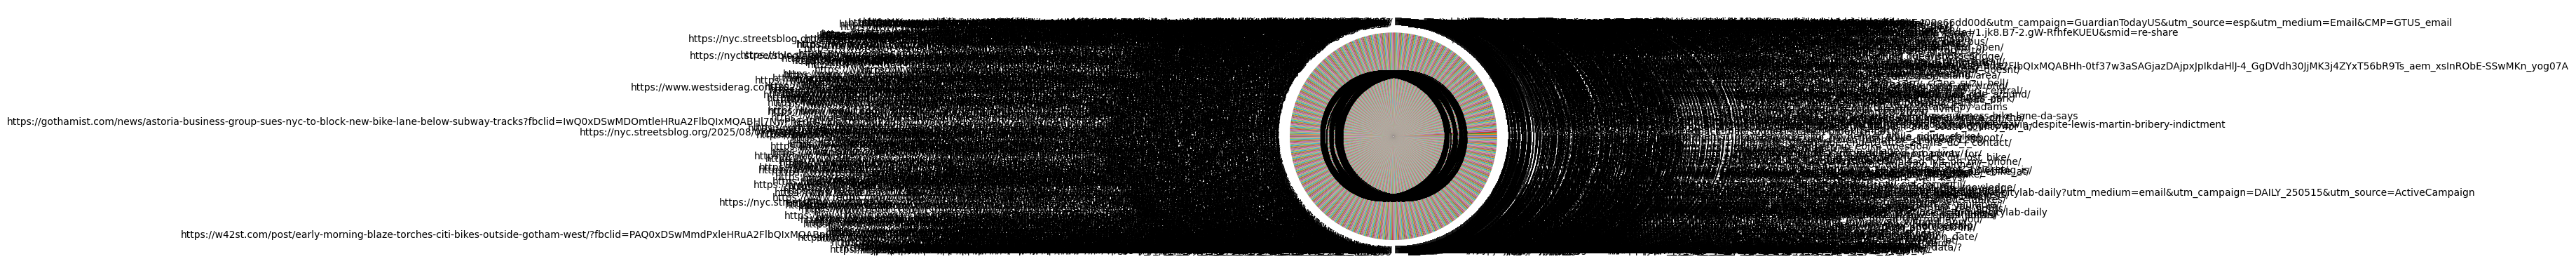

In [ ]:
#This generates the pie chart for a specific column

column ="source_url" #Insert Column of Ineterst Here
generate_pie(column = column)

#Activity 2: Data Preprocessing

Now that you have a basic understanding of your dataset. Let's prepare it for automated data analysis.

Your goal here is to properly clean your data that would make subsequent data analysis easier. Some (non-comprehensive) things to consider:

- converting emojis to equivalent text.
- perform lemmatization. (words like <code>shop</code>, <code>SHOP</code>, <code>shopping</code>, <code>shopper</code>, <code>shops</code> discuss the same general topic; ideally these should be treated as one word)
- how to deal with capitalization and punctuations?

We also provide a list of abbreviations that will get automatically expanded. Please download [here](https://drive.google.com/file/d/1b8XfDzofhgcyAqbBuojfdkEA0EEuUHi8/view?usp=drive_link) and upload.

We enourage you to come up with some of your preprocessing ideas which you belive may make data analysis easier. If needed, don't be afraid to to ask for help!



In [ ]:
#Helper method for cleaning text based off various rules
def clean_text(text, banned_word_list=[], abbreviation_dictionary={}, replace_emoji=True, length_threshold=0):
  if(replace_emoji):
    text = emoji.demojize(text)
  else:
    text = emoji.replace_emoji(text,replace="")
  def remove_links(text):
    text_arr = text.split()
    text_arr = [word for word in text_arr if "http" not in word]
    return ' '.join(text_arr)
  text = remove_links(text)
  terms_to_clear = {sp_char: '' for sp_char in string.punctuation}
  terms_to_clear['_'] = ' '
  terms_to_clear[' '] = ' '
  table = str.maketrans(terms_to_clear)
  text1 = text.translate(table)
  textArr = text1.split()
  text2 = ' '.join([w for w in textArr if len(w) >= length_threshold and w not in banned_word_list])
  for word in text2.split():
    if word in abbreviation_dictionary:
      text2 = text2.replace(word, abbreviation_dictionary[word])
  return text2.lower()

In [ ]:
#This is an example on how to clean the text
text = "Hi how is, it going in NYC 🏡 https://google.com" #Example text to be cleaned
banned_word_list = ["hi","hello"] #List of banned words, these words get deleted
abbreviation_dictionary = {"NYC":"New York City", "LA":"Los Angeles"} #Abbvreviations to expand
replace_emoji = True #Determines whether emoji should be replaced with textual name or simply deleted
length_threshold = 3 #Minimum length of word to be included

print(f"Original: {text}")
print(f"Modified: {clean_text(text,banned_word_list,abbreviation_dictionary,replace_emoji,length_threshold)}")

Original: Hi how is, it going in NYC 🏡 https://google.com
Modified: how going new york city house with garden


Add a few more examples. Play around with the cleaning parameters.

In [ ]:
# --- Load abbreviations (replace sample_data path; use pandas for safety) ---
import pandas as pd

abbr = pd.read_csv("abbreviations.csv", header=None, names=["abbr","full"])
abbreviations_dict = dict(zip(abbr["abbr"].astype(str).str.strip(),
                              abbr["full"].astype(str).str.strip()))

# --- Clean all comments on the Reddit dataset (not bike_share_data) ---
# fall back to 'body' if your file doesn't have 'comment'
base_col = 'comment' if 'comment' in reddit.columns else 'body'

# if banned_word_list not defined earlier, default to empty list
banned_word_list = banned_word_list if 'banned_word_list' in globals() else []

reddit_backup = reddit.copy()  # keep original for comparison
reddit["text_clean"] = reddit[base_col].astype(str).apply(
    clean_text, args=(banned_word_list, abbreviations_dict, True, 3)
)

# --- Print a before/after example (use iloc to avoid key/quote issues) ---
idx = 188  # or any valid index you want to inspect
print("Original:", reddit_backup[base_col].iloc[idx])
print("Modified:", reddit["text_clean"].iloc[idx])


Original: Citi bike overcharge Ive been citi-biking for five years and every time I dock my electric bike and check the app to enure it is docked the timer is still running ranging from 10-30 seconds depending on how fast I open the app. That's 10-30 more seconds that I have to pay to them FOR FREE. This company is so fucking greedy.  
Modified: citi bike overcharge ive been citibiking for five years and every time dock electric bike and check the app enure docked the timer still running ranging from 1030 seconds depending how fast open the app thats 1030 more seconds that have pay them for free this company fucking greedy


In [ ]:
#Helper method to lemmatize the text
nlp = en_core_web_md.load(disable=['parser', 'ner'])
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ']):
  output = []
  for sent in texts:
    doc = nlp(sent)
    output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
  return output

Lemmatization is a complex process in Natural Language Processing. Broadly, it does a lot of work to examine the parts of speech of words and see if they are the same lemma, or base word. Our code also ignores all parts of speech besides nouns and adjectives.

Running = run = ran

fun = joy

In [ ]:
#Here are example runs of lemmatization to give you a feel for how this process works

print(lemmatization(["biking bike"]))
print(lemmatization(["better best good worst worse bad"]))
print(lemmatization(["INSERT WORDS HERE"]))

[['bike']]
[['good', 'bad']]
[['word']]


Try running lemmatization on your own set of words

In [ ]:
base_col = 'text_clean' if 'text_clean' in reddit.columns else (
    'comment' if 'comment' in reddit.columns else 'body'
)

clean_list = reddit[base_col].astype(str).tolist()
text_list = reddit["comment"].tolist()
lemmatized_texts = lemmatization(text_list)

for i in range(3):
    print(f"Original Comment {i}: {reddit["comment"][i]}")
    print(f"Clean Comment {i}: {reddit[base_col].iloc[i]}")
    print(f"Lemmatized Comment {i}: {lemmatized_texts[i]}\n")


Original Comment 0: r/CitiBike Lost and Found #Please use this thread to note bikes that are missing or have been located.   **THIS LIST IS NOT OFFICAL**. We are not affiliated in anyway with CitiBike or Lyft.     Last Update: 1/26/25  Lost | Found | Date | Location | User ---|---|----|----|----- 320-1159 | |1/26/25|   grand st / Allen st|/u/Krazy8901 |  |884-5786|1/12/25| 4th street and palisade ave in union city nj|/u/SubstantialBudget394 |  5982814||12/19/24|cypress ave and Troutman|/u/Mira_2020 |  |55715|12/16/24|LES |/u/VGK_46 |  |782-3768 |11/26/24| |/u/VGK_46 |  |584-5881|11/26/24| | /u/VGK_46|  |533-4693 |11/26/24| | /u/VGK_46| 465-5957| |11/10/24|  Willson ave  Bk|/u/Lazy_Technology_6823 | 40624 | |11/10/24|  164 court st|/u/Straight_Age7698 | 6215651 | |11/4/24|  87B Mayard (Chinatown)|/u/OuAllonsNous | 86248 | |11/3/24| near 110 and cathedral parkway|/u/Sea_Cricket_3891 | 2692408| |10/14/24| LIC 21st and 43 Ave|/u/opeggeeo |  |6544555 |10/12/24| 67th and Broadway| | 4926143|

# Activity 3: Sentiment Analysis via LIWC and Data Visualization

Now that our data is ready. Let's do data analysis! Our first task is to do sentiment analysis on our dataset. Is there mostly a positive attitude towards bike sharing? Are the bikers unhappy about using the bike sharing app? What is the general sentiment in the comments that we have collected. For this we will use a popular tool called [Linguistic Inquiry and Word Count (LIWC)](https://www.liwc.app/) to extrac the sentiment.

We can then use the extracted sentiments from the comments to visualize our data in a 2D plot. For this we will use [tSNE/UMAP](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) visualization tool.


## Understanding LIWC Processing

[Linguistic Inquiry and Word Count (LIWC)](https://www.liwc.app/) is a popular linguistic analysis tool that can analyze the input text on multiple *dimensions*

- Emotional processes: Positive/negative emotions, anxiety, anger, sadness
- Cognitive processes: Insight, causation, discrepancy, tentative language
- Social processes: Family, friends, social references
- Personal concerns: Work, money, religion, death, health

It works by comparing words in a given text to a built-in dictionary organized into categories such as emotions, thinking styles, social concerns, and personal motives. LIWC is frequently applied in psychology, communication, and social science research to uncover patterns in how people express themselves. Its outputs provide numerical summaries that can reveal underlying psychological states or group-level differences in language use.

Your first task is to try LIWC for yourself. Try the [demo](https://www.liwc.app/demo) by copy/pasting some of the user comments from your dataset. What kinds of scores do you get? Try it on some of your own comments to understand the LIWC scoring system.

We have already processed our user comments dataset with LIWC and you can download the LIWC processed data from [here](https://drive.google.com/file/d/1Dg8jv4KYJoMLLx6KLHQU9PA3xmWJtpO1/view?usp=drive_link). As before, upload this dataset to this notebook for sentiment analysis.

Your next task is to understand the general user sentiment in our dataset. Some (non-comprehensive) things to consider:

- What proportion of comments are in positive tone?
- What are some of the most *angry* comments
- Are there any comments in the suggestive tone?

Of course, we enourage you to come up with your own sentiment related questions to understand your dataset. If needed, don't be afraid to to ask for help!



In [ ]:
# Loads in LIWC scores
liwc_scores = pd.read_csv("liwc_reddit_data.csv").fillna(0)
text_col = next((c for c in ['Text','text','body','comment'] if c in liwc_scores.columns), None)

non_metric = {'id','author','subreddit','created','score','permalink','url','Text','text','body','comment'}
liwc_cols = [c for c in liwc_scores.columns if c not in non_metric]

print("First few LIWC categories:", liwc_cols[:10])

First few LIWC categories: ['source_url', 'Segment', 'Analytic', 'Clout', 'Authentic', 'Drives', 'affiliation', 'achieve', 'power', 'Cognition']


In [ ]:
#Helper method to generate the LIWC histogram
def generate_liwc_hist(column, bucket_size, color="skyblue"):
    vals = liwc_scores[column].dropna()
    lo = int(min(vals))
    hi = int(max(vals)) + bucket_size
    bins = list(range(lo, hi, bucket_size))
    plt.hist(vals, bins=bins, color=color, edgecolor='black')
    plt.xlabel(f"{column} score")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {column} Score Frequencies")
    plt.show()


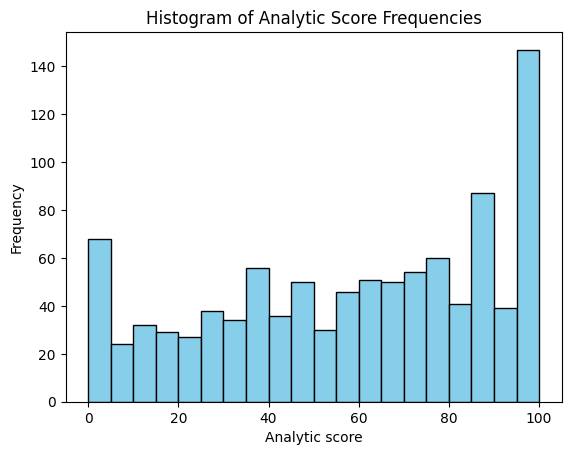

In [ ]:
category = "Analytic" #Insert Category Here
bucket_size = 5 #Insert Value Here

generate_liwc_hist(category,bucket_size)

In [ ]:
#List user comments with logical thinking
category = "Analytic" #Insert Category Here
threshold = 99 #Insert Value Here
print('\n'.join(list(liwc_scores.loc[liwc_scores[category] >= threshold]["Text"])))

Left a bag on citibike at 72 & Columbus - help!
Citi bike dock at NE corner of Franklin & Eastern in Crown Heights - gone
NYC pol wants to force Citi Bike to install system to ban kids from riding e-bikes
I biked to 100 Citibike stations in a day
biker number 3314507 stolen at 36th street between 7th ave and broadway right in front of Zen ramen
James May races the subway by CitiBike.
The visible display. First time for this.
Little something from a project I'm working on (Ridership trend in 2021 overlaid with mean feels like temp)
How many points for balancing a Citibike in the middle of the Washington Square Fountain
The Life of the Most-Used Citi Bike in New York City
The Life of the Most-Used Citi Bike in New York City
Stolen Stolen Citibike on  Lafayette
found keys in citibike basket
Station down on 48th St at Skillman Ave Sunnyside. This curb lane station on the SE corner appears to have been hit by a wrong-way/wrong-side car or backed over by a truck.
Points to dollar value for e

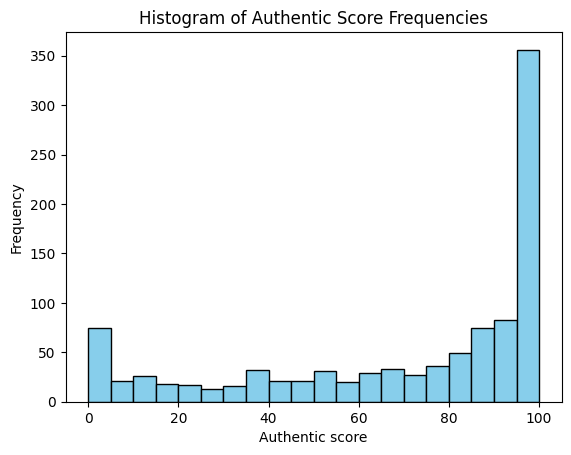

In [ ]:
category2 = "Authentic" #Insert Category Here
bucket_size = 5 #Insert Value Here

generate_liwc_hist(category2,bucket_size)

In [ ]:
#List user comments with positive tone
category2 = "Authentic" #Insert Category Here
threshold = 99 #Insert Value Here
print('\n'.join(list(liwc_scores.loc[liwc_scores[category2] >= threshold]["Text"])))

Left bag in citibike (UES Station) I know this is a longshot but I left a tote bag with a notebook and a book in a citibike docked on 77th and 1st yesterday evening. If anyone has seen it let me know!
Free Ebike Rides w Lyft Pink ? Have ridden a few times this week since moving back to the city (from SF and Lyft bikes) and they've all come out to 0.00? What are these Ebike minutes used coming out to a negative price?
Left card case on citibike Left a green card case on or around a citibike last weekend in Bushwick. Forgot to ask on here if folks have come across it.
My first (and last) Citibike Century Ride [100 miles] https://youtu.be/DItbNYh4W58?s
Anyone know when they’re going to start adding new stations in the expansion areas? All I’ve heard is “fall 2025”.
Are there new lighter blue bikes? I couldn't find anything online about it but I rode a blue bike for the first time in a year maybe (lately I either use my bike or a Citi white/e-bike) and it seemed lighter and easier to deal 

play with the LIWC parameter settings above and list the comments with the following tones

*   List some of the user comments which are complaints. What are some of the complaints?
*   List some of the user comments which are negative comments.



## 2D tSNE/UMAP Visualization of User Comments

We will now visualize our dataset in aggregate to reveal salient themes. We will use [tSNE/UMAP](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) visualization tool for this.

tSNE and UMAP are nonlinear dimensionality reduction techniques that are commonly used for visualizing high-dimensional data in two or three dimensions. They work by preserving local structure, that is data (i.e. user comments) that are close together in the original dataset are embedded close in the lower-dimensional plot, making salient clusters more apparent. These techniques are widely used in fields like machine learning, bioinformatics, and natural language processing to explore complex datasets.

Your task here is to run tSNE and UMAP on your dataset. There are key tuning parameters, play with the tuning parameters to come up with an effective data visualization. Question to answer: what effect does changing the parameters on the 2D output?

In [ ]:
# --- Get a few important LIWC columns
preferred = [
    "Analytic", "Tone",
    "posemo", "negemo", "anx", "anger", "sad",
    "affiliation", "achieve", "power", "cogproc",
    "work", "need", "want", "tech"
]
selected_columns = [c for c in preferred if c in liwc_scores.columns]
assert len(selected_columns) >= 2, f"No expected LIWC columns found. Available: {list(liwc_scores.columns)[:30]}"

liwc_np = liwc_scores[selected_columns].astype(float).to_numpy()
mu = liwc_np.mean(axis=0, keepdims=True)
sigma = liwc_np.std(axis=0, ddof=0, keepdims=True)
sigma[sigma == 0] = 1.0
liwc_np_std = (liwc_np - mu) / sigma

def generate_dr_plot(dr_type, cluster_coords=None):
    if dr_type.lower() == "tsne":
        n = liwc_np_std.shape[0]
        perplexity = max(5, min(30, n // 50 if n >= 1000 else 15))
        model = TSNE(n_components=2, random_state=0, perplexity=perplexity)
    elif dr_type.lower() == "umap":
        n_neighbors = max(5, min(30, liwc_np_std.shape[0] // 50 if liwc_np_std.shape[0] >= 1000 else 15))
        model = umap.UMAP(n_components=2, random_state=0, n_neighbors=n_neighbors, min_dist=0.1)
    else:
        print("Invalid DR Type")
        return None

    plot_data = model.fit_transform(liwc_np_std)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(plot_data[:, 0], plot_data[:, 1], s=50, alpha=0.7)
    ax.set_title("Dimensionally Reduced Scatter Plot")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.grid(True)

    if cluster_coords:
        rect_x, rect_y, rect_w, rect_h = cluster_coords
        rectangle = Rectangle((rect_x, rect_y), rect_w, rect_h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rectangle)

    plt.show()

    if cluster_coords:
        base_col = 'text_clean' if 'text_clean' in reddit.columns else (
            'comment' if 'comment' in reddit.columns else 'body'
        )

        if 'id' in liwc_scores.columns and 'id' in reddit.columns:
            comment_series = liwc_scores['id'].map(reddit.set_index('id')[base_col]).reset_index(drop=True)
        else:
            comment_series = reddit[base_col].reset_index(drop=True)

        rect_x, rect_y, rect_w, rect_h = cluster_coords
        chunk = [
            comment_series.iloc[i]
            for i, (x, y) in enumerate(plot_data)
            if (rect_x < x < rect_x + rect_w) and (rect_y < y < rect_y + rect_h)
        ]
        return chunk

    return None


Once the scatter plot is created, you will also have a chance to create a rectangle on the graph by toggling the
```
rect_x,rect_y,rect_w,rect_h
```
variables, which stand for the rectangle x and y coordinate (the bottom left corner), the width, and the height, respectively. You will need to insert nonsense values for the first go to see the plot get generated, but after that, try selecting the appropriate values to get the rectangle to surround the cluster you are looking at. These comments will be saved later!


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


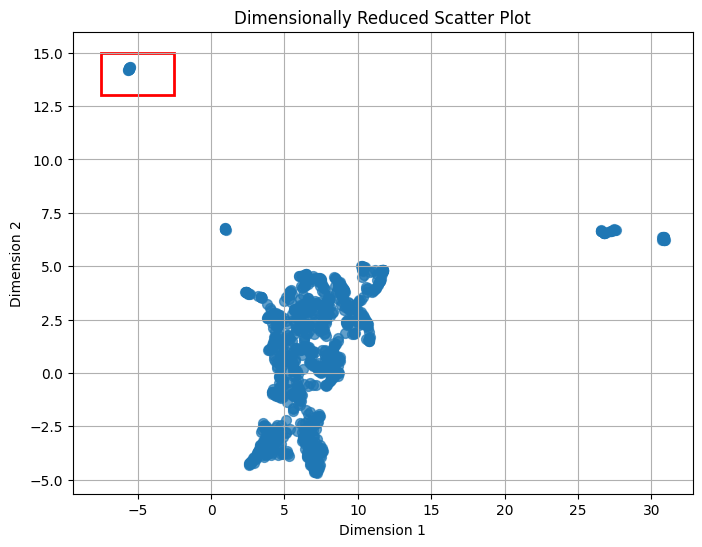

In [ ]:
reduction_type_2 = "UMAP" #Options to use are "UMAP" or "TSNE"
rect_x_2,rect_y_2 = -7.5,13 #Bottom left corner of rectangle format xx,xx
rect_w_2 = 5 #Rectangle width
rect_h_2 = 2 #Rectangle height

cluster_2 = generate_dr_plot(reduction_type_2,(rect_x_2,rect_y_2,rect_w_2,rect_h_2))

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


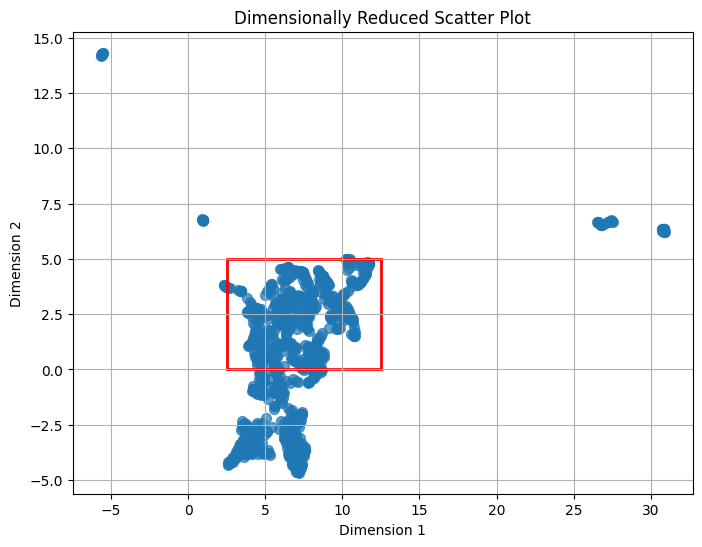

In [ ]:
reduction_type = "UMAP" #Options to use are "UMAP" or "TSNE"
rect_x,rect_y = 2.5,0 #Bottom left corner of rectangle format xx,xx
rect_w = 10 #Rectangle width
rect_h = 5 #Rectangle height

cluster = generate_dr_plot(reduction_type,(rect_x,rect_y,rect_w,rect_h))

## Word Cloud Data Visualization of Clusters

Now that you have a pretty 2D visualization of your dataset that shows some interesting cluster structure. These clusters or groups are a collection of user comments that are supposed to be similar to each other (e.g. they are all negative comments, or they are all suggestions on app improvements, or they are all dicussing lack of bike docks).

Let's try to drill down and examine some these groups to see what these grouped comments are discussing. For this we can use [Word Cloud](https://en.wikipedia.org/wiki/Tag_cloud) visualization.

A word cloud is a visual representation of text data in which the size of each word reflects its frequency or importance within the source text. Commonly used words appear larger and bolder, while less frequent ones appear smaller. Word clouds provide a quick and intuitive way to identify dominant themes or topics in large collections of text. They are often used in exploratory text analysis, presentations, and data visualization to highlight key terms at a glance.

Your task here is to examine some of the clusters from the visualization you produced in the previous part and understand what the users are talking about.
Some (non-comprehensive set of) questions for your to investigate:
- which groups/clusters are associated with positive comments on bike sharing?
- for the user complaints, what are the main issues that are being raised?

In [ ]:
#Helper method to generate word cloud
def generate_word_cloud(text,eliminated_words=[]):
  text = text.lower()
  for word in eliminated_words:
    text = text.replace(word, "")
  temp = ["s","ed","ing","ly","rs","ning","al","ation"]
  for t in temp:
    text = text.replace(" " + t + " ","")
  text = text.split(" ")
  for word in text:
    if(len(word) <= 2):
      text.remove(word)
  # Create word cloud
  text = ' '.join(text)
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

  # Display it
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.title("Word Cloud")
  plt.show()

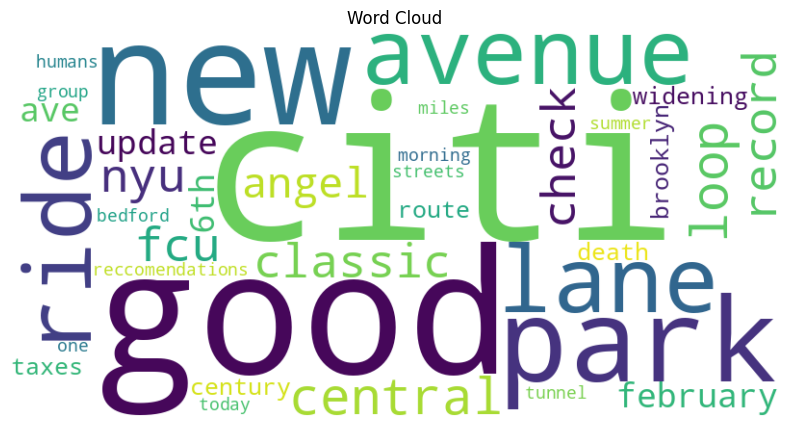

In [ ]:
eliminated_words = ["bike","share","station","different"]#Insert Words Here

text_2 = ' '.join(cluster_2) #Takes cluster and glues all the words together
generate_word_cloud(text_2,eliminated_words)

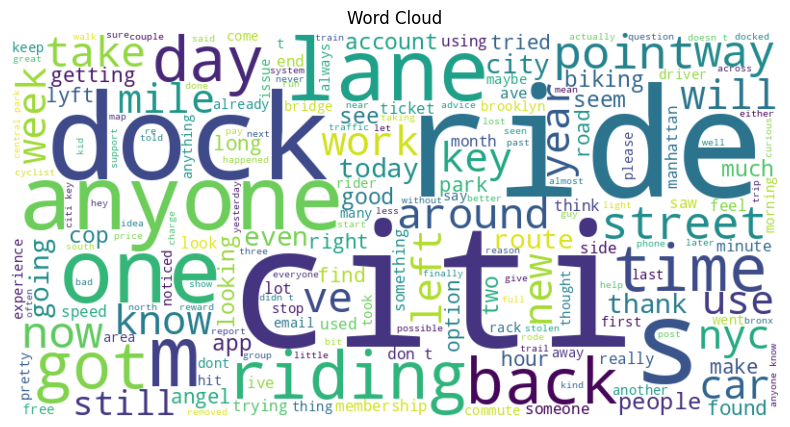

In [ ]:
eliminated_words = ["bike","share","station","different"]#Insert Words Here

text = ' '.join(cluster) #Takes cluster and glues all the words together
generate_word_cloud(text,eliminated_words)

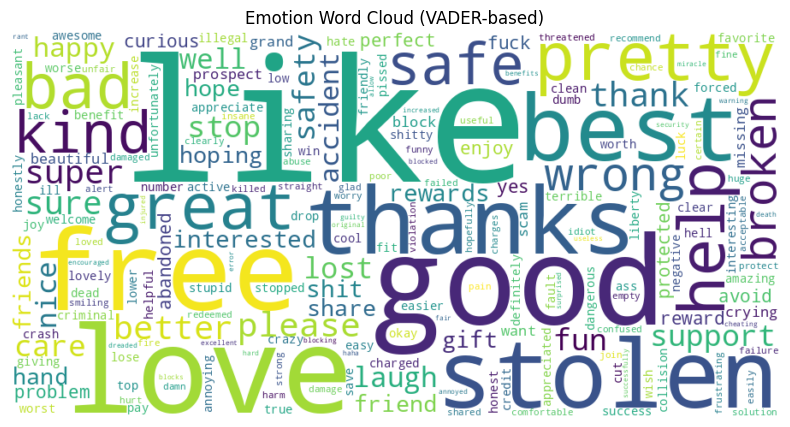

In [ ]:
# Emotion-only word cloud (keep ONLY emotion-bearing words via VADER lexicon)

# 1) choose the text column
base_col = 'text_clean' if 'text_clean' in reddit.columns else (
    'comment' if 'comment' in reddit.columns else 'body'
)

# 2) ensure we have a VADER lexicon in memory
try:
    sia
except NameError:
    from nltk.sentiment import SentimentIntensityAnalyzer
    import nltk; nltk.download('vader_lexicon', quiet=True)
    sia = SentimentIntensityAnalyzer()

# 3) build an emotion vocabulary from VADER (stricter: |score| >= 0.2)
emotion_vocab = {w for w, s in sia.lexicon.items() if abs(s) >= 0.2}

# 4) collect tokens and filter to emotion words only
tokens = []
for txt in reddit[base_col].astype(str):
    tokens.extend(txt.lower().split())

emo_tokens = [w for w in tokens if w in emotion_vocab and len(w) > 2]

# 5) weight by lexicon intensity so stronger emotion words stand out
from collections import Counter
cnt = Counter(emo_tokens)
freqs = {w: cnt[w] * abs(sia.lexicon.get(w, 0.0)) for w in cnt}

# 6) word cloud
wc = WordCloud(width=900, height=450, background_color='white').generate_from_frequencies(freqs)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Emotion Word Cloud (VADER-based)')
plt.show()


#Activity 4: Topic Modeling via LDA

The Latent Dirichlet Allocation (LDA) model is a method used to discover hidden themes or topics within a collection of texts. It assumes that each document is made up of a mixture of different topics, and each topic is represented by a set of words that often appear together. By analyzing patterns of word use across documents, LDA groups words into topics and shows how much each topic contributes to each document. This makes it a popular tool for uncovering themes in large collections of articles, books, or other written material.

Your task here is to run the LDA model on your dataset and investigate what topics and themes does it discover. There are key tuning parameters (alpha and beta) in the LDA model. Play with the tuning parameters and see how the results change. Question to answer: what effect does changing the parameters have on the topics/themes the model discover?

In [ ]:
# LDA Helper (English, fixed & robust)
# Notes:
# - Accepts lemmatized_texts as List[str] or List[List[str]]; converts to List[List[str]].
# - If tfidf=True, keeps the top (term_percentile) share of terms by mean TF-IDF, updates `dropped_terms`.
# - Returns a gensim LdaModel.

dropped_terms = []

def LDA(num_topics=6, random_state=100, chunksize=1000, passes=50, iterations=100,
        alpha=0.2, tfidf=True, term_percentile=0.56):
    # 1) Normalize docs to token lists
    docs = lemmatized_texts
    if not docs:
        raise ValueError("lemmatized_texts is empty.")
    if isinstance(docs[0], str):
        docs = [d.split() for d in docs]

    # 2) Optional TF-IDF filtering (keep highest-weight terms)
    if tfidf:
        combined_texts = [' '.join(doc) for doc in docs]
        tfidf_vec = TfidfVectorizer()
        X = tfidf_vec.fit_transform(combined_texts)
        means = np.asarray(X.mean(axis=0)).ravel()

        k = max(1, int(term_percentile * X.shape[1]))
        order = means.argsort()[::-1]          # high -> low
        keep_idx = order[:k]
        drop_idx = order[k:]

        inv_vocab = {v: k for k, v in tfidf_vec.vocabulary_.items()}
        keep_terms = {inv_vocab[i] for i in keep_idx}
        dropped_terms[:] = [inv_vocab[i] for i in drop_idx]

        docs_filtered = [[w for w in doc if w in keep_terms] for doc in docs]
        docs_filtered = [doc for doc in docs_filtered if len(doc) > 0]
        if not docs_filtered:                   # fallback if filtering too aggressive
            docs_filtered = docs
    else:
        docs_filtered = docs

    # 3) Dictionary & corpus
    c_dictionary = corpora.Dictionary(docs_filtered)
    if len(c_dictionary) == 0:
        raise ValueError("Dictionary is empty after filtering. Relax TF-IDF or check inputs.")
    doc_term_matrix = [c_dictionary.doc2bow(doc) for doc in docs_filtered]
    if not any(len(bow) > 0 for bow in doc_term_matrix):
        raise ValueError("Doc-term matrix is empty. Check tokenization/filtering.")

    # 4) Train LDA
    LDAClass = gensim.models.ldamodel.LdaModel
    return LDAClass(
        corpus=doc_term_matrix,
        id2word=c_dictionary,
        num_topics=num_topics,
        random_state=random_state,
        chunksize=chunksize,
        passes=passes,
        iterations=iterations,
        alpha=alpha
    )


In [ ]:
num_topics = 5 #Number of topics to separate
chunksize = 1000 #Approximate chunksize for a topic
passes = 50 #Number of passes
iterations = 100 #Number of iterations
alpha = 0.2 #Distribution Parameter
tfidf = True #TFIDF preprocessing
term_percentile = 0.56 #TFIDF threshold parameter

lda_model = LDA(num_topics = num_topics,chunksize = chunksize,passes = passes,iterations = iterations,alpha = alpha,tfidf = True,term_percentile = term_percentile)

In [ ]:
# Helper: get comments for a specific topic (1-based topic_number)
def get_comments_for_topic(topic_number):
    # use the same docs used to train LDA; normalize to token lists
    docs = lemmatized_texts
    if isinstance(docs[0], str):
        docs = [d.split() for d in docs]

    # build bows with the model's dictionary (no re-TFIDF here)
    dict_obj = lda_model.id2word
    bows = [dict_obj.doc2bow(doc) for doc in docs]

    # dense topic distributions (handle empty bows safely)
    num_t = lda_model.num_topics
    doc_topic_array = np.zeros((len(bows), num_t))
    for i, bow in enumerate(bows):
        topics = lda_model.get_document_topics(bow, minimum_probability=0.0)
        for tid, p in topics:
            doc_topic_array[i, tid] = p

    # pick docs whose top topic matches (1-based -> 0-based)
    target = topic_number - 1
    idxs = np.where(doc_topic_array.argmax(axis=1) == target)[0]

    # return original comments (fallback order: comment -> body -> text_clean)
    base_col = 'comment' if 'comment' in reddit.columns else (
        'body' if 'body' in reddit.columns else 'text_clean'
    )
    result_arr = reddit.iloc[idxs][base_col].astype(str).tolist()
    result_str = " ".join(result_arr)
    return result_str, result_arr


In [ ]:
topic_number = 2  # 1-based index: Topic 1 means internal id 0

# simple call (new signature)
result_str, result_arr = get_comments_for_topic(topic_number)

if not result_arr:
    print(f"No comments found for topic {topic_number}")
else:
    for i, c in enumerate(result_arr[:5], 1):
        print(f"[{i}] {c}")

[1] Chat in app problems? Can anyone access chat via app?  On August 23rd I attempted chat help via the CitiBike app then the Lyft app without success   I took an e-bike after the dock would not unlock the sole classic bike. I was charged afterwards and wanted remimbursement   The chat option for both Citibike and Lyft apps just kept cycling and would not bring me to a chat window. I finally emailed them via the CitiBike webpage  
[2] Needing A Lot Of Force To Ride Yesterday was my first citibike ride. It was tiring! I switched between many bikes and most of them were hard to petal / move fast. In completely flat areas it's ok but a little bit of hill requires alot of petaling force. Yet the people around me were zooming past me with ease without even petaling much! I eventually had to stop from excessive sweating. Funny thing is that I'm not too out of shape. I exersize wekly so why is biking so tiresome while others seem to do it with ease?  I enjoyed the ride and would love to conti

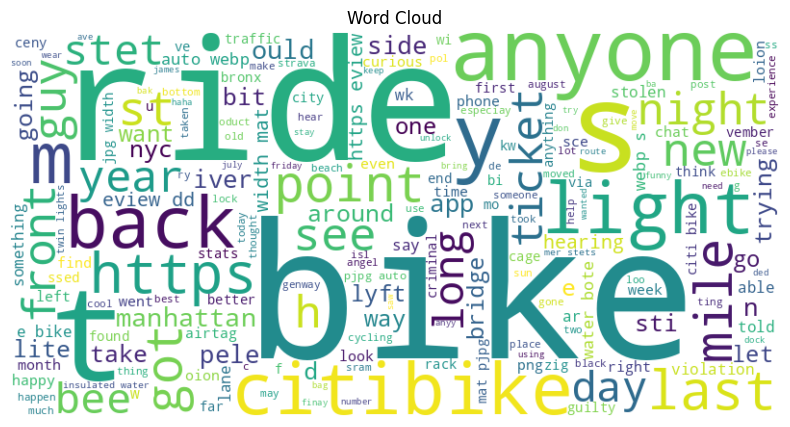

In [ ]:
eliminated_words = dropped_terms#Insert Words Here
text = ' '.join(result_arr) #Takes cluster and glues all the words together
generate_word_cloud(result_str,eliminated_words)

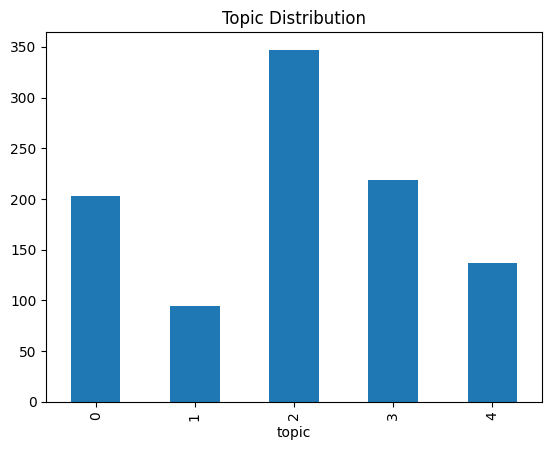

In [ ]:
# Assign dominant topic per document
docs = lemmatized_texts
if isinstance(docs[0], str):
    docs = [d.split() for d in docs]

dict_obj = lda_model.id2word
bows = [dict_obj.doc2bow(doc) for doc in docs]

num_t = lda_model.num_topics
import numpy as np
doc_topic = np.zeros((len(bows), num_t))
for i, bow in enumerate(bows):
    for tid, p in lda_model.get_document_topics(bow, minimum_probability=0.0):
        doc_topic[i, tid] = p

reddit['topic'] = doc_topic.argmax(axis=1).astype(int)
reddit['topic'].value_counts().sort_index().plot(kind='bar', title='Topic Distribution')
plt.show()


# Insights

In [ ]:
# reddit comments sort by frequency
sorted_word_frequency = sorted(word_frequency.items(), key=lambda item: item[1], reverse=True)

for word, count in sorted_word_frequency[:100]:
    print(f"{word}: {count}")

the: 2869
and: 1655
bike: 1086
for: 830
this: 623
that: 574
was: 477
but: 470
you: 454
have: 432
with: 432
are: 325
citibike: 319
not: 309
ride: 295
they: 287
just: 286
from: 284
bikes: 277
there: 242
get: 242
out: 239
like: 224
can: 221
what: 207
one: 199
any: 196
when: 195
all: 192
anyone: 191
would: 186
has: 184
had: 180
i’m: 171
about: 171
how: 166
been: 160
new: 160
citi: 144
riding: 141
back: 139
your: 139
know: 138
lyft: 134
got: 133
time: 132
them: 132
membership: 132
lane: 132
some: 131
now: 130
more: 127
their: 126
park: 125
way: 124
city: 120
around: 119
dock: 114
nyc: 113
it’s: 110
which: 104
street: 102
then: 102
were: 100
will: 100
use: 99
other: 99
take: 97
see: 97
could: 94
does: 93
here: 93
where: 93
after: 93
day: 92
into: 91
points: 91
only: 91
who: 89
even: 89
going: 88
looking: 88
over: 87
did: 87
before: 86
these: 85
down: 85
station: 84
than: 83
people: 83
first: 82
want: 82
off: 82
also: 81
biking: 79
why: 78
while: 78
good: 78
right: 78
work: 77


In [ ]:
#top user comments with logical thinking under analytic category Liwc
category = "Analytic" #Insert Category Here
threshold = 99 #Insert Value Here
print('\n'.join(list(liwc_scores.loc[liwc_scores[category] >= threshold]["Text"])))

Left a bag on citibike at 72 & Columbus - help!
Citi bike dock at NE corner of Franklin & Eastern in Crown Heights - gone
NYC pol wants to force Citi Bike to install system to ban kids from riding e-bikes
I biked to 100 Citibike stations in a day
biker number 3314507 stolen at 36th street between 7th ave and broadway right in front of Zen ramen
James May races the subway by CitiBike.
The visible display. First time for this.
Little something from a project I'm working on (Ridership trend in 2021 overlaid with mean feels like temp)
How many points for balancing a Citibike in the middle of the Washington Square Fountain
The Life of the Most-Used Citi Bike in New York City
The Life of the Most-Used Citi Bike in New York City
Stolen Stolen Citibike on  Lafayette
found keys in citibike basket
Station down on 48th St at Skillman Ave Sunnyside. This curb lane station on the SE corner appears to have been hit by a wrong-way/wrong-side car or backed over by a truck.
Points to dollar value for e

In [ ]:
#top user comments with tentative language under analytic category Liwc
category = "Analytic" #Insert Category Here
threshold = 1 #Insert Value Here
print('\n'.join(list(liwc_scores.loc[liwc_scores[category] <= threshold]["Text"])))

Is it just me or does it feel like it’s even slower than 15mph now? I thought I would get used to the 15mph but honestly lately it feels even slower.
Confirmation bikes have been feeling extremely slow lately so i finally messaged them and wow 15mph.  This will be my last time with the membership anyone else?
New Central Park Loop Classic CitiBike Record 21:01
Why isn't it working?
Cops beware. 67th & CPW
People don’t ride classic bikes anymore?
E-bike rewards - $0.12 ($0.13) E-bike rewards got reverse Nerf $0.25-$0.12=$0.13.
It’s over
NYU FCU Citibike
It never shipped what’s the deal?
https://gothamist.com/news/citi-bike-rushes-to-add-speedometers-after-mayor-adams-orders-15-mph-e-bike-speed-limit
Citibike’s 2025 Pride Decal
Check your app If your bike number is either 203-5426 or 221-0623 your bike is still ongoing 😭🙏🏾
Let’s share our CitiBike stats! I’ll start with mine!
Floating Bike Never seen this before
Who's stealing handlebar grips?
anyone else have 2 of these
Check citibike A

Analytic: This variable measures analytical and structured thinking. High scores are associated with formal, logical, and hierarchical thinking, while low scores are linked to more personal, narrative, and informal styles.

In [ ]:
#List user comments with personal tone
category2 = "Authentic" #Insert Category Here
threshold = 99 #Insert Value Here
print('\n'.join(list(liwc_scores.loc[liwc_scores[category2] >= threshold]["Text"])))

Left bag in citibike (UES Station) I know this is a longshot but I left a tote bag with a notebook and a book in a citibike docked on 77th and 1st yesterday evening. If anyone has seen it let me know!
Free Ebike Rides w Lyft Pink ? Have ridden a few times this week since moving back to the city (from SF and Lyft bikes) and they've all come out to 0.00? What are these Ebike minutes used coming out to a negative price?
Left card case on citibike Left a green card case on or around a citibike last weekend in Bushwick. Forgot to ask on here if folks have come across it.
My first (and last) Citibike Century Ride [100 miles] https://youtu.be/DItbNYh4W58?s
Anyone know when they’re going to start adding new stations in the expansion areas? All I’ve heard is “fall 2025”.
Are there new lighter blue bikes? I couldn't find anything online about it but I rode a blue bike for the first time in a year maybe (lately I either use my bike or a Citi white/e-bike) and it seemed lighter and easier to deal 

In [ ]:
#List user comments with artificial tone
category2 = "Authentic" #Insert Category Here
threshold = 1 #Insert Value Here
print('\n'.join(list(liwc_scores.loc[liwc_scores[category2] <= threshold]["Text"])))

NYC asks Lyft to require ID for Citi Bike e-bikes to curb underage riders
Cops on chrystie and delacey giving tickets
NYC pol wants to force Citi Bike to install system to ban kids from riding e-bikes
James May races the subway by CitiBike.
This one had an adventure.
Cops beware. 67th & CPW
Keys left at 71st 3rd ave dock Whoever this was we retrieved them and are looking for whose these are.
E-bike rewards - $0.12 ($0.13) E-bike rewards got reverse Nerf $0.25-$0.12=$0.13.
Has anyone successfully got your phone unbanned? Got banned because I have two phones (work and personal) and was using the app on both.  Support only replies with terms of service.  Was anyone successfully unbanned their phones?
What is wrong with this clown of a mayor ?? What’s his issue with E bikes he have way bigger 🐟 to fry
Three abandoned bikes!!! W70 and CPW
NYU FCU Citibike
https://gothamist.com/news/citi-bike-rushes-to-add-speedometers-after-mayor-adams-orders-15-mph-e-bike-speed-limit
Citibike’s 2025 Pride 

Authentic: This variable distinguishes between more personal, honest, and unguarded language (high scores) and more guarded, distant, and artificial language (low scores).

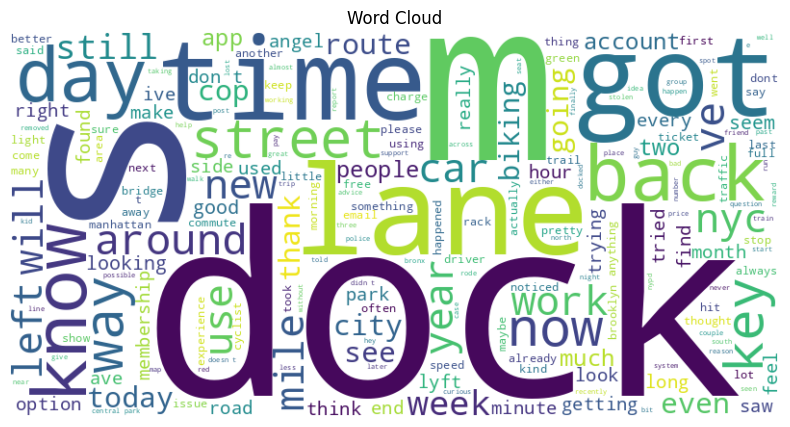

In [ ]:
# the most mentioned word through recorded reddit comments(excluding bike, share, station, and different)
eliminated_words = ["bike","share","station","different", "ride", "citi", "anyone", "point", "take", "one", "anyone", "riding"]#Insert Words Here

text = ' '.join(cluster) #Takes cluster and glues all the words together
generate_word_cloud(text,eliminated_words)

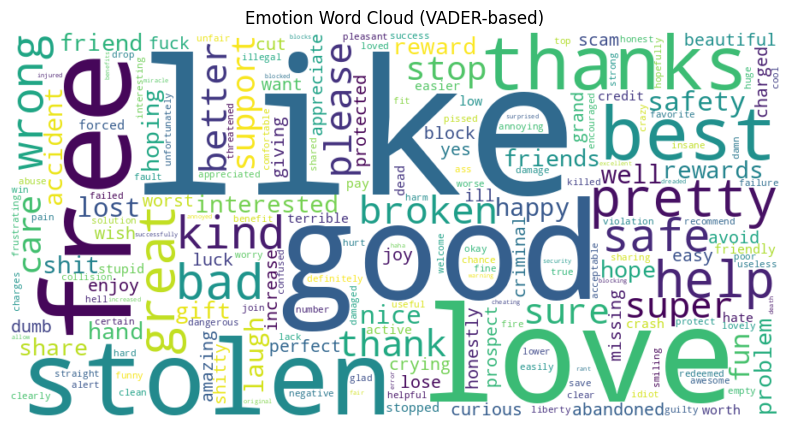

In [ ]:
# Sentiment Analysis with Vader lexicon

# 1) choose the text column
base_col = 'text_clean' if 'text_clean' in reddit.columns else (
    'comment' if 'comment' in reddit.columns else 'body'
)

# 2) ensure we have a VADER lexicon in memory
try:
    sia
except NameError:
    from nltk.sentiment import SentimentIntensityAnalyzer
    import nltk; nltk.download('vader_lexicon', quiet=True)
    sia = SentimentIntensityAnalyzer()

# 3) build an emotion vocabulary from VADER (stricter: |score| >= 0.2)
emotion_vocab = {w for w, s in sia.lexicon.items() if abs(s) >= 0.2}

# 4) collect tokens and filter to emotion words only
tokens = []
for txt in reddit[base_col].astype(str):
    tokens.extend(txt.lower().split())

emo_tokens = [w for w in tokens if w in emotion_vocab and len(w) > 2]

# 5) weight by lexicon intensity so stronger emotion words stand out
from collections import Counter
cnt = Counter(emo_tokens)
freqs = {w: cnt[w] * abs(sia.lexicon.get(w, 0.0)) for w in cnt}

# 6) word cloud
wc = WordCloud(width=900, height=450, background_color='white').generate_from_frequencies(freqs)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Emotion Word Cloud (VADER-based)')
plt.show()